In [1]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv
import sys
sys.path.append("../../../spatial-clust-scripts-main/")
import model
import warnings
import numpy as np
import leidenalg
import igraph as ig
import scanpy as sc
import anndata as ad
from sklearn.neighbors import NearestNeighbors
from collections import defaultdict
import graph
import pandas as pd
import scipy
import skimage
# import custom functions
import utils
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
import seaborn as sns
import umap
# from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from validclust import dunn
from sklearn.metrics import pairwise_distances
plt.rcParams["figure.figsize"] = (8, 6)


/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## during testing only test snap_gnn

class SNAP_GNN(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.fc = nn.Linear(in_features=args.gnn_input_dim, out_features=args.fc_dim)
        self.cnn_fc = nn.Linear(in_features=args.cnn_input_dim, out_features=args.cnn_dim)
        self.feat_conv1 = GCNConv(args.fc_dim, args.latent_dim)
        self.feat_conv2 = GCNConv(args.latent_dim, args.fc_out_dim)
        
        self.spat_conv1 = GCNConv(args.cnn_dim, args.cnn_latent_dim)
        self.spat_conv2 = GCNConv(args.cnn_latent_dim, args.cnn_out_dim)
        
        self.proj1 = nn.Linear(in_features=args.fc_out_dim+args.cnn_out_dim, 
                              out_features=args.hid_out_dim)
        self.proj2 = nn.Linear(in_features=args.hid_out_dim, 
                              out_features=args.out_dim)

    def feat_gnn_encoder(self, feat, feat_edge_index):
        feat = F.relu(self.fc(feat))
        feat = F.relu(self.feat_conv1(feat, feat_edge_index))
        feat = self.feat_conv2(feat, feat_edge_index)
        
        return feat
    
    def spat_gnn_encoder(self, spat, spat_edge_index):
        spat = F.relu(self.cnn_fc(spat))
        spat = F.relu(self.spat_conv1(spat, spat_edge_index))
        spat = self.spat_conv2(spat, spat_edge_index)
        
        return spat
    
    def encoder(self, feat, spat, feat_edge_index, spat_edge_index):
        x_feat = self.feat_gnn_encoder(feat, feat_edge_index)
        x_spat = self.spat_gnn_encoder(spat, spat_edge_index)
        x = torch.cat((x_feat, x_spat), dim = 1)
        return x
    

    def forward(self, feat, spat, feat_edge_index, spat_edge_index):
        x = F.relu(self.encoder(feat, spat, feat_edge_index, spat_edge_index))
        x = self.proj1(x)
        x = F.relu(x)
        x = self.proj2(x)
        return x


In [3]:
class Args:
    gnn_input_dim = 31
    cnn_input_dim = 128
    fc_dim = latent_dim = 32
    cnn_dim = cnn_latent_dim = 32
   # out_dim = 14 * 2 # dont know this value yet
    fc_out_dim = 33
    cnn_out_dim = 11
    hid_out_dim = 33

    criterion = "L1"
    learning_rate = 1e-3
    epochs = 10000
    print_every = 1000
    average_iter = 100
    device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

args = Args()

In [4]:
def get_gnn_embed(model, cell_nbhd, feat, spat, feat_edge_index, spat_edge_index, verbose=False):
    optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
    cell_nbhd = cell_nbhd.to(args.device)
    model = model.to(args.device)
    if args.criterion == "L1":
        print("Use L1 Loss")
        criterion = nn.L1Loss()
    elif args.criterion == "L2":
        print("Use L2 Loss")
        criterion = nn.MSELoss()
    else:
        print("Cross Entropy")
        criterion = nn.CrossEntropyLoss()

    train_loss_epoch = []
    #criterion = nn.L1Loss()
    for e in range(1, 1+args.epochs):
        model.train()
        predicted_nbhd = model(features, cnn_embedding, feat_edge_index, spat_edge_index)
        # Compute prediction error
        loss = criterion(predicted_nbhd, cell_nbhd)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        # take one step
        optimizer.step()

        # record the loss
        curr_train_loss = loss.item()
        if verbose and e % args.print_every  == 0:
            print(f'===Epoch {e}, the training loss is {curr_train_loss:>0.8f}==', flush=True)
        train_loss_epoch.append(curr_train_loss)
    return model.encoder(feat, spat, feat_edge_index, spat_edge_index).cpu().detach().numpy()


  0%|          | 0/5 [00:00<?, ?it/s]/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


0
Use L1 Loss
===Epoch 1000, the training loss is 0.02475370==
===Epoch 2000, the training loss is 0.02111059==
===Epoch 3000, the training loss is 0.01982375==
===Epoch 4000, the training loss is 0.01905892==
===Epoch 5000, the training loss is 0.01853176==
===Epoch 6000, the training loss is 0.01814512==
===Epoch 7000, the training loss is 0.01816363==
===Epoch 8000, the training loss is 0.01778882==
===Epoch 9000, the training loss is 0.01748825==
===Epoch 10000, the training loss is 0.01731282==
1
Use L1 Loss
===Epoch 1000, the training loss is 0.02407485==
===Epoch 2000, the training loss is 0.02113619==
===Epoch 3000, the training loss is 0.01991309==
===Epoch 4000, the training loss is 0.01894094==
===Epoch 5000, the training loss is 0.01821564==
===Epoch 6000, the training loss is 0.01773426==
===Epoch 7000, the training loss is 0.01754759==
===Epoch 8000, the training loss is 0.01714265==
===Epoch 9000, the training loss is 0.01666784==
===Epoch 10000, the training loss is 0.0

 20%|██        | 1/5 [1:45:20<7:01:23, 6320.79s/it]

0
Use L1 Loss
===Epoch 1000, the training loss is 0.02514497==
===Epoch 2000, the training loss is 0.02188711==
===Epoch 3000, the training loss is 0.02018398==
===Epoch 4000, the training loss is 0.01944750==
===Epoch 5000, the training loss is 0.01874046==
===Epoch 6000, the training loss is 0.01845971==
===Epoch 7000, the training loss is 0.01811387==
===Epoch 8000, the training loss is 0.01791976==
===Epoch 9000, the training loss is 0.01758231==
===Epoch 10000, the training loss is 0.01736899==
1
Use L1 Loss
===Epoch 1000, the training loss is 0.02483378==
===Epoch 2000, the training loss is 0.02029190==
===Epoch 3000, the training loss is 0.01891778==
===Epoch 4000, the training loss is 0.01818678==
===Epoch 5000, the training loss is 0.01764277==
===Epoch 6000, the training loss is 0.01718258==
===Epoch 7000, the training loss is 0.01745577==
===Epoch 8000, the training loss is 0.01698287==
===Epoch 9000, the training loss is 0.01675115==
===Epoch 10000, the training loss is 0.0

 40%|████      | 2/5 [3:06:12<4:32:49, 5456.37s/it]

0
Use L1 Loss
===Epoch 1000, the training loss is 0.02579557==
===Epoch 2000, the training loss is 0.02254631==
===Epoch 3000, the training loss is 0.02127854==
===Epoch 4000, the training loss is 0.02053216==
===Epoch 5000, the training loss is 0.01995207==
===Epoch 6000, the training loss is 0.01974021==
===Epoch 7000, the training loss is 0.01928741==
===Epoch 8000, the training loss is 0.01898906==
===Epoch 9000, the training loss is 0.01851271==
===Epoch 10000, the training loss is 0.01806666==
1
Use L1 Loss
===Epoch 1000, the training loss is 0.02499346==
===Epoch 2000, the training loss is 0.02209076==
===Epoch 3000, the training loss is 0.02036187==
===Epoch 4000, the training loss is 0.01934271==
===Epoch 5000, the training loss is 0.01898334==
===Epoch 6000, the training loss is 0.01813900==
===Epoch 7000, the training loss is 0.01755021==
===Epoch 8000, the training loss is 0.01724403==
===Epoch 9000, the training loss is 0.01690798==
===Epoch 10000, the training loss is 0.0

 60%|██████    | 3/5 [4:27:09<2:52:45, 5182.92s/it]

0
Use L1 Loss
===Epoch 1000, the training loss is 0.02462214==
===Epoch 2000, the training loss is 0.02160399==
===Epoch 3000, the training loss is 0.02024149==
===Epoch 4000, the training loss is 0.01928656==
===Epoch 5000, the training loss is 0.01859030==
===Epoch 6000, the training loss is 0.01805163==
===Epoch 7000, the training loss is 0.01762781==
===Epoch 8000, the training loss is 0.01728936==
===Epoch 9000, the training loss is 0.01741981==
===Epoch 10000, the training loss is 0.01711481==
1
Use L1 Loss
===Epoch 1000, the training loss is 0.02532270==
===Epoch 2000, the training loss is 0.02122663==
===Epoch 3000, the training loss is 0.01986336==
===Epoch 4000, the training loss is 0.01907345==
===Epoch 5000, the training loss is 0.01907725==
===Epoch 6000, the training loss is 0.01840297==
===Epoch 7000, the training loss is 0.01815685==
===Epoch 8000, the training loss is 0.01762840==
===Epoch 9000, the training loss is 0.01746572==
===Epoch 10000, the training loss is 0.0

 80%|████████  | 4/5 [5:37:15<1:19:57, 4797.20s/it]

0
Use L1 Loss
===Epoch 1000, the training loss is 0.02459314==
===Epoch 2000, the training loss is 0.02132483==
===Epoch 3000, the training loss is 0.01998611==
===Epoch 4000, the training loss is 0.01909646==
===Epoch 5000, the training loss is 0.01846113==
===Epoch 6000, the training loss is 0.01800133==
===Epoch 7000, the training loss is 0.01767125==
===Epoch 8000, the training loss is 0.01751241==
===Epoch 9000, the training loss is 0.01752608==
===Epoch 10000, the training loss is 0.01733809==
1
Use L1 Loss
===Epoch 1000, the training loss is 0.02386334==
===Epoch 2000, the training loss is 0.02066036==
===Epoch 3000, the training loss is 0.01939391==
===Epoch 4000, the training loss is 0.01866840==
===Epoch 5000, the training loss is 0.01816473==
===Epoch 6000, the training loss is 0.01816424==
===Epoch 7000, the training loss is 0.01769999==
===Epoch 8000, the training loss is 0.01759394==
===Epoch 9000, the training loss is 0.01737091==
===Epoch 10000, the training loss is 0.0

100%|██████████| 5/5 [6:15:31<00:00, 4506.40s/it]  


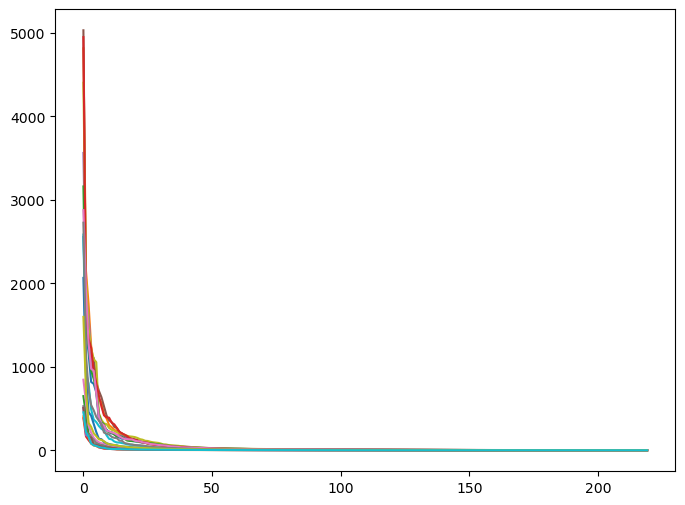

In [5]:
### input
size = 512
l = 1
d = defaultdict(list)

for i in tqdm(range(5)):
    for a in [0.2, 0.5, 0.7, 1]:
        
        metaload_path = '/mnt/cloud1/sheng-projects/st_projects/spatial_clust/spatial-clust-scripts/ipynb/Bokai_reorg/benchmark/spleen/data/'
        df_clean = pd.read_csv('/mnt/cloud1/sheng-projects/st_projects/spatial_clust/spatial-clust-scripts/ipynb/Bokai_reorg/spleen/data/features_and_metadata.csv', index_col=0)
        features = np.load('/mnt/cloud1/sheng-projects/st_projects/spatial_clust/spatial-clust-scripts/ipynb/Bokai_reorg/spleen/data/feature_scaled.npy')
        
        cell_nbhd = np.load(os.path.join(metaload_path,  f"cell_nbhd_res{a}_k20.npy"))
        train_mask = np.load(os.path.join(metaload_path,  "train_mask.npy"))
        feature_labels = np.load(os.path.join(metaload_path,  f"feature_labels_res{a}.npy"))
        feature_edges = np.load(os.path.join(metaload_path,  "feature_edges_res0.5.npy")) # edge does not change due to res
        spatial_edges = np.load(os.path.join(metaload_path,  "spatial_edges_0326.npy"))                       
                               
        # change into torch
        features = torch.from_numpy(features).float().to(args.device)
        feat_edge_index = torch.from_numpy(np.array(feature_edges.T[:2])).long().to(args.device)
        spat_edge_index = torch.from_numpy(np.array(spatial_edges.T[:2])).long().to(args.device)
        
        # combo nbhd                       
        df_clean['res'] = feature_labels
        reslabel = pd.get_dummies(df_clean['res'])
        combo_nbhd = np.hstack([reslabel, cell_nbhd])
        combo_nbhd = torch.from_numpy(combo_nbhd).float().to(args.device)
        
        ## cnn
        load_path = '/mnt/cloud1/sheng-projects/st_projects/spatial_clust/spatial-clust-scripts/ipynb/Bokai_reorg/benchmark/spleen/data/'
        save_folder = os.path.join(load_path, "cnn", f"cnn_512_l{l}_layer6_testres:{a}_checkpoints", "epochs", 'embed')
        args.out_dim = combo_nbhd.shape[1]
        
        #### reset args here
        class Args:
            gnn_input_dim = 31
            cnn_input_dim = 128
            fc_dim = latent_dim = 32
            cnn_dim = cnn_latent_dim = 32
            out_dim = combo_nbhd.shape[1]

            fc_out_dim = 33
            cnn_out_dim = 11
            hid_out_dim = 33

            criterion = "L1"
            learning_rate = 1e-3
            epochs = 10000
            print_every = 1000
            average_iter = 100
            device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

        args = Args()
        #### reseat args finished
        
        # get cnn embedding
        epoch = 400
        cnn_embedding = np.load(os.path.join(save_folder, f'cnn_512_testres:{a}_l1_layer6_byepoch' ,f"cnn_embedding_512_full_l1_dim128_epoch{epoch}.npy"))
        cnn_embedding = torch.from_numpy(cnn_embedding).float().to(args.device)
        cnn = cnn_embedding
        
        stable = True
        if stable:
            rep = 5
            dim = args.fc_out_dim + args.cnn_out_dim
            concat_embedding = np.zeros((features.shape[0], rep * dim))
            for i in range(rep):
                print(i)
                gnn_embedding = get_gnn_embed(SNAP_GNN(args), combo_nbhd, features, cnn, feat_edge_index, spat_edge_index, verbose=True)
                concat_embedding[:, i*dim : (i+1)*dim] = gnn_embedding
            Ue, Se, Vhe = np.linalg.svd(concat_embedding, full_matrices=False)

            plt.plot(Se)
            k = 32
            gnn_embedding = Ue[:, :k] @ np.diag(Se[:k])
        else:
            gnn_embedding = get_gnn_embed(SNAP_GNN(args), combo_nbhd, features, cnn, feat_edge_index, spat_edge_index, verbose=True)

        ## save out
        dir = '../data/saved_embedding/nbhd_res' + str(a) + '_dbGNN_0327.npy'
        np.save(dir, gnn_embedding)
